<a href="https://colab.research.google.com/github/mha2160-glitch/mha2160-glitch.github.io/blob/main/final_project_mha2160.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Analyzing How Economic News Frames Political Figures**

## **1. Introduction**

"It’s the economy, stupid." James Carville’s famous 1992 campaign strategy highlights a universal truth in politics: economic conditions align with the direction of political course. However, in the age of digital media, economic reality often competes with economic perception.

This project investigates the disconnect between economic data and media narratives. Specifically, how news outlets frame economic policy decisions and political figures. Does the language used in economic reporting shift based on the sentiment of the news? By analyzing news headlines and article bodies, this project explores how the media "constructs" the economy for the voting public.

**Background: Framing Theory and the "Vibecession"**

To understand why this analysis is necessary for economic policy, we must look at Framing Theory. In communication studies, "framing" refers to how media highlights certain aspects of a perceived reality to promote a specific interpretation.

Recently, economists have noted a phenomenon dubbed the "Vibecession", where public sentiment about the economy is overwhelmingly negative despite strong fundamental indicators like low unemployment and GDP growth. This suggests that the text of economic news (the qualitative data) might be just as influential as the numbers (the quantitative data).

Similar to how Mamdani successfully won the Majoral Race in NYC through media discourse, economic crises can be constructed or mitigated through the specific vocabulary journalists choose. If news reports use "crisis" terminology even during stable periods, they frame the policy environment as hostile, potentially influencing voter behavior and consumer confidence.

**Research Question**: Does the economic news frames policy communication? Does the media frame economic "losses" (negative news) and economic "gains" (positive news) symmetrically? Does "neutral" reporting actually signal a specific type of policy stance?

**Data Collection**

To ensure high-precision analysis, this project utilizes the NewsMTSC (Multi-Target-Dependent Sentiment Classification) dataset.

Unlike standard datasets that label entire articles as "positive" or "negative," NewsMTSC provides sentence-level annotations focused on specific targets (e.g., specific politicians, policies, or economic entities). This allows for a much more granular analysis, isolating exactly how the media speaks about political figures within the context of economic news.

I programmatically retrieved the training corpus (train.jsonl) from the official repository. The dataset contains sentences extracted from high-quality news outlets, expertly annotated with sentiment labels (Positive, Negative, Neutral) relative to the mentioned target.

**Methodology: Sentiment Grouping + TF-IDF**

Raw text is sometimes noisy. To extract meaningful patterns, this project employed two primary Natural Language Processing (NLP) techniques:

**Ground-Truth Sentiment Grouping:** <br>
Instead of relying on automated lexicons (like VADER) which can struggle with sarcasm or complex political context, I utilized the MTSC dataset's human-verified sentiment labels. This ensures that the text buckets (Positive, Negative, Neutral) represent true semantic meaning, providing a "Gold Standard" foundation for analysis.

**TF-IDF (Term Frequency-Inverse Document Frequency):** <br>
To understand how the framing differs between these buckets, I calculated TF-IDF scores. This technique helps identify the "signature words" of each sentiment group by weighing terms that are unique to that group while filtering out common words (like "the" or "said") that appear everywhere.

### **2. Exploratory Data Analysis and Data Cleaning**

In [ ]:
# Install required libraries
import json
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from wordcloud import WordCloud

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import TfidfVectorizer

# Download NLTK data (run once)
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
# Steps to load the data
def load_mtsc_data():

    # URL for the Raw MTSC Train Data
    url = "https://raw.githubusercontent.com/fhamborg/NewsMTSC/main/NewsSentiment/controller_data/datasets/NewsMTSC-dataset/train.jsonl"

    print(f"Downloading data from {url}...")
    response = requests.get(url)

    data = []

    # Process the JSONL (JSON Lines) format
    if response.status_code == 200:
        lines = response.text.strip().split('\n')
        for line in lines:
            entry = json.loads(line)

            # Get sentence and primary_gid from the entry
            # Using 'sentence_normalized' as 'sentence' appears to be empty based on user feedback
            sentence_text = entry.get('sentence_normalized', '')
            primary_gid_val = entry.get('primary_gid', None)

            # Each sentence might have multiple targets, we take all of them
            if 'targets' in entry:
                for target in entry['targets']:
                    # Extract target-specific sentiment
                    # Standard MTSC format: 'polarity' might be 6.0 (positive) to 2.0 (negative)
                    data.append({
                        'sentence': sentence_text,
                        'primary_gid': primary_gid_val,
                        'target': target.get('term', ''),
                        'target_gid': target.get('Input.gid', None),
                        'polarity': target.get('polarity', None),
                    })

        textdata = pd.DataFrame(data)
        print(f"Successfully loaded {len(textdata)} rows.")
        return textdata
    else:
        print("Failed to download data.")
        return None

# Load the data
textdata = load_mtsc_data()

# Quick look at the data structure
if textdata is not None:
    print(textdata.head())
    print("\nSentiment Counts:")
    print(textdata['polarity'].value_counts()) # Changed to polarity for consistency with next cell

Successfully loaded 8739 rows.
                                            sentence  \
0  Winner wrote that she had a 30-minute private ...   
1  She also recently referred to President Trump ...   
2  She also recently referred to President Trump ...   
3  Hillary Clinton blamed the Democratic National...   
4  Hillary Clinton blamed the Democratic National...   

                                     primary_gid target  \
0  allsides_1000_401_25_Reality Leigh Winner_0_6          
1   allsides_1000_401_3_Reality Leigh Winner_0_3          
2   allsides_1000_401_3_Reality Leigh Winner_0_3          
3       allsides_1018_408_1_Hillary Clinton_2_17          
4       allsides_1018_408_1_Hillary Clinton_2_17          

                                      target_gid  polarity  
0  allsides_1000_401_25_Reality Leigh Winner_0_6       4.0  
1   allsides_1000_401_3_Reality Leigh Winner_0_3       2.0  
2              allsides_1000_401_3_’ Trump_30_45       2.0  
3       allsides_1018_408_1_Hilla

Next, we examine the pre-assigned sentiment labels. According to MTSC publications, the sentiment polarity concerning the target entity is quantified as follows: 2.0 denotes negative, 4.0 denotes neutral, and 6.0 denotes positive. To restrict our analysis to the economic domain, we filter the dataset using a targeted lexicon of economics-related keywords. This narrowing of scope allows us to specifically investigate the extent to which economic news coverage influences policy communication.

In [ ]:
# Framing dataset of polarity label
polarity_to_label = {
    2.0: "negative",
    4.0: "neutral",
    6.0: "positive"
}

textdata["sentiment"] = textdata["polarity"].map(polarity_to_label)
textdata["sentiment"].value_counts()

,count
sentiment,
negative,3316
neutral,3028
positive,2395


In [ ]:
# Filtering Out Econ Keywords
econ_keywords = [
    "economy", "economic", "economics",
    "tax", "taxes", "budget", "deficit", "surplus",
    "debt", "spending", "welfare",
    "jobs", "employment", "unemployment", "wage", "wages", "income",
    "growth", "recession", "inflation", "depression",
    "trade", "tariff", "exports", "imports",
    "market", "stock", "stocks", "bond", "bonds",
    "financial", "finance", "bank", "banks", "wall street", "treasury",
    "policy", "interest rates", "fiscal policy", "monetary policy", "reforms",
    "subsidies", "bailout", "debt ceiling", "consumer spending", "GDP"
]

pattern = re.compile("|".join(re.escape(k) for k in econ_keywords), re.IGNORECASE)

text_econ = textdata[textdata["sentence"].str.contains(pattern, na=False)]
text_econ = text_econ.reset_index(drop=True)

print("Total rows (all):", len(textdata))
print("Finance/econ rows:", len(text_econ))
text_econ.head()

Total rows (all): 8739
Finance/econ rows: 699


,sentence,primary_gid,target,target_gid,polarity,sentiment
0,Winner wrote that she had a 30-minute private ...,allsides_1000_401_25_Reality Leigh Winner_0_6,,allsides_1000_401_25_Reality Leigh Winner_0_6,4.0,neutral
1,White House senior policy adviser Stephen Mill...,allsides_113_46_1_White House senior policy ad...,,allsides_113_46_1_White House senior policy ad...,2.0,negative
2,Trump Senior Policy Adviser Stephen Miller on ...,allsides_115_46_7_Michael Wolff_46_51,,allsides_115_46_7_Michael Wolff_46_51,2.0,negative
3,"In Lebanon, thank you to Yazan al-Saadi, Syria...",allsides_1197_477_198_Yazan al-Saadi_25_39,,allsides_1197_477_198_Yazan al-Saadi_25_39,6.0,positive
4,Some even thought MSNBC host Rachel Maddow’s a...,allsides_1271_509_4_Maddow_29_42,,allsides_1271_509_4_Maddow_29_42,4.0,neutral


## **3. Data Visualization**

To examine the data distribution following the cleaning process, we visualize the dataset using a simple bar chart. Although this step is optional, it provides a great opportunity to verify that the data quality and quantity are sufficient before proceeding with the analysis.

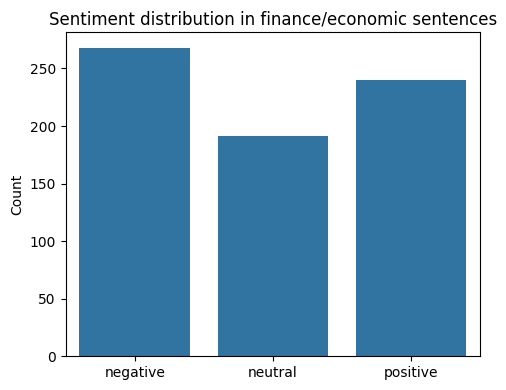

Initial Economic-Related Words sentiment
negative    268
neutral     191
positive    240
Name: count, dtype: int64


In [ ]:
# Initial sentiment distribution
sent_counts = text_econ["sentiment"].value_counts().sort_index()

plt.figure(figsize=(5,4))
sns.barplot(x=sent_counts.index, y=sent_counts.values)
plt.title("Sentiment distribution in finance/economic sentences")
plt.ylabel("Count")
plt.xlabel("")
plt.tight_layout()
plt.show()

print(f"Initial Economic-Related Words", sent_counts)

In [ ]:
# Initialize NLTK
# Standard English stopwords
pre_stop_words = set(stopwords.words("english"))
pre_lemmatizer = WordNetLemmatizer()

def nltk_tokenizer_pre_stopwords(text):
    if not isinstance(text, str):
        return []
    text = text.lower()
    text = re.sub(r"http\S+|www\.\S+", " ", text)   # remove URLs
    tokens = word_tokenize(text)
    tokens = [t for t in tokens if t.isalpha()]     # words only
    tokens = [t for t in tokens if t not in pre_stop_words] # Use only standard stopwords
    tokens = [pre_lemmatizer.lemmatize(t) for t in tokens]
    return tokens

print("Defined nltk_tokenizer_pre_stopwords function.")

Defined nltk_tokenizer_pre_stopwords function.


In [ ]:
from collections import Counter

# Tokenize all economic sentences using the updated tokenizer (with extra stopwords)
all_econ_tokens = []
for sentence in text_econ['sentence']:
    all_econ_tokens.extend(nltk_tokenizer(sentence))

# Count word frequencies
word_counts = Counter(all_econ_tokens)

# Get the top N most frequent words
top_n_words = 20  # You can adjust this number
most_common_words = word_counts.most_common(top_n_words)

# Convert to DataFrame for plotting
df_most_common = pd.DataFrame(most_common_words, columns=['term', 'count'])

/tmp/ipython-input-2248614265.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='count', y='term', data=df_most_common.sort_values(by='count', ascending=True), palette='viridis')


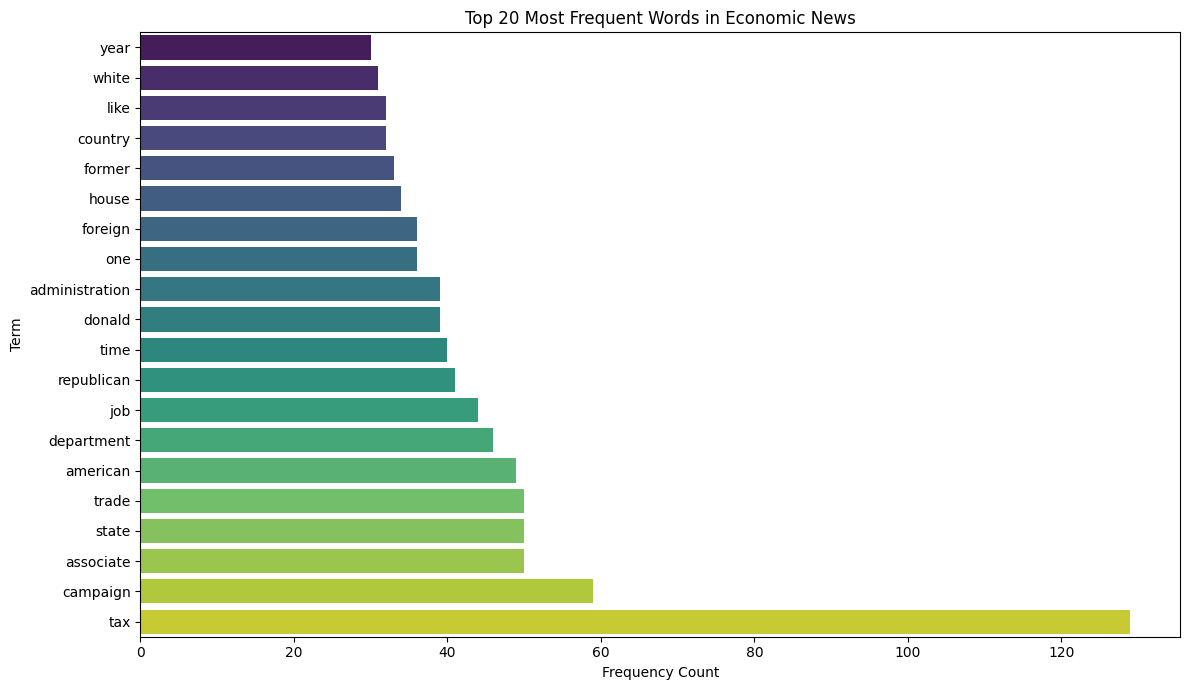

In [ ]:
# Plot the top most common words
top_n_words = 20

plt.figure(figsize=(12, 7))
sns.barplot(x='count', y='term', data=df_most_common.sort_values(by='count', ascending=True), palette='viridis')
plt.title(f'Top {top_n_words} Most Frequent Words in Economic News')
plt.xlabel('Frequency Count')
plt.ylabel('Term')
plt.tight_layout()
plt.show()

/tmp/ipython-input-2929331831.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='count', y='term', data=df_most_common_sentiment.sort_values(by='count', ascending=True), palette='viridis')


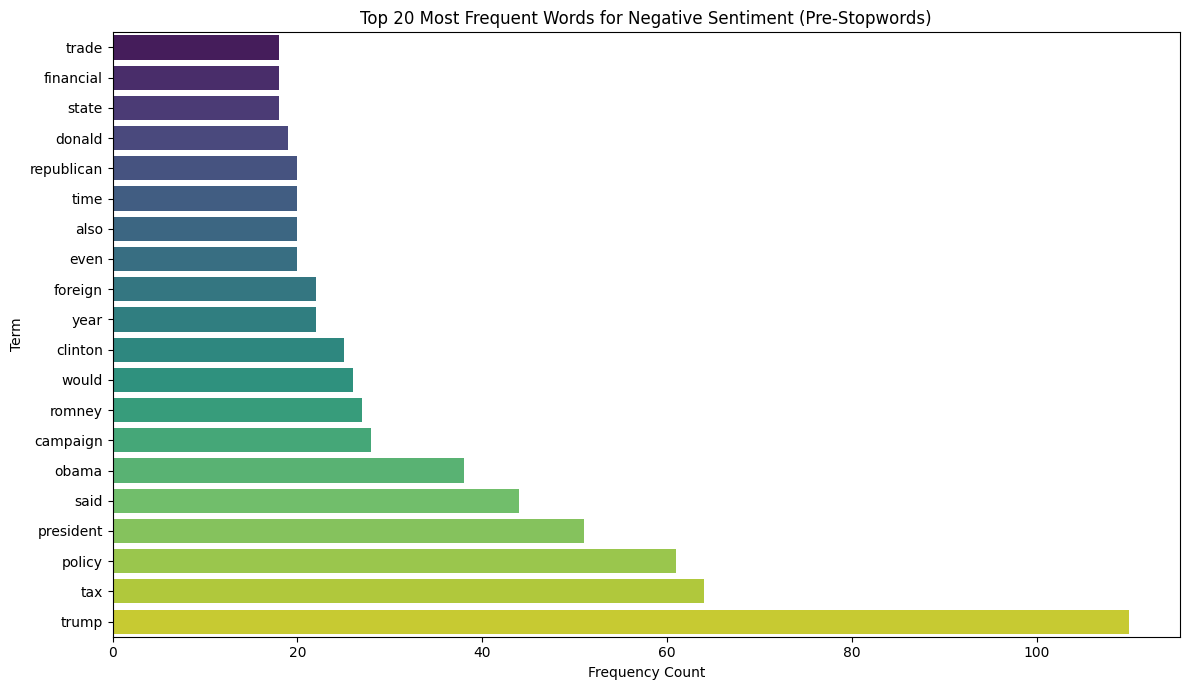

/tmp/ipython-input-2929331831.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='count', y='term', data=df_most_common_sentiment.sort_values(by='count', ascending=True), palette='viridis')


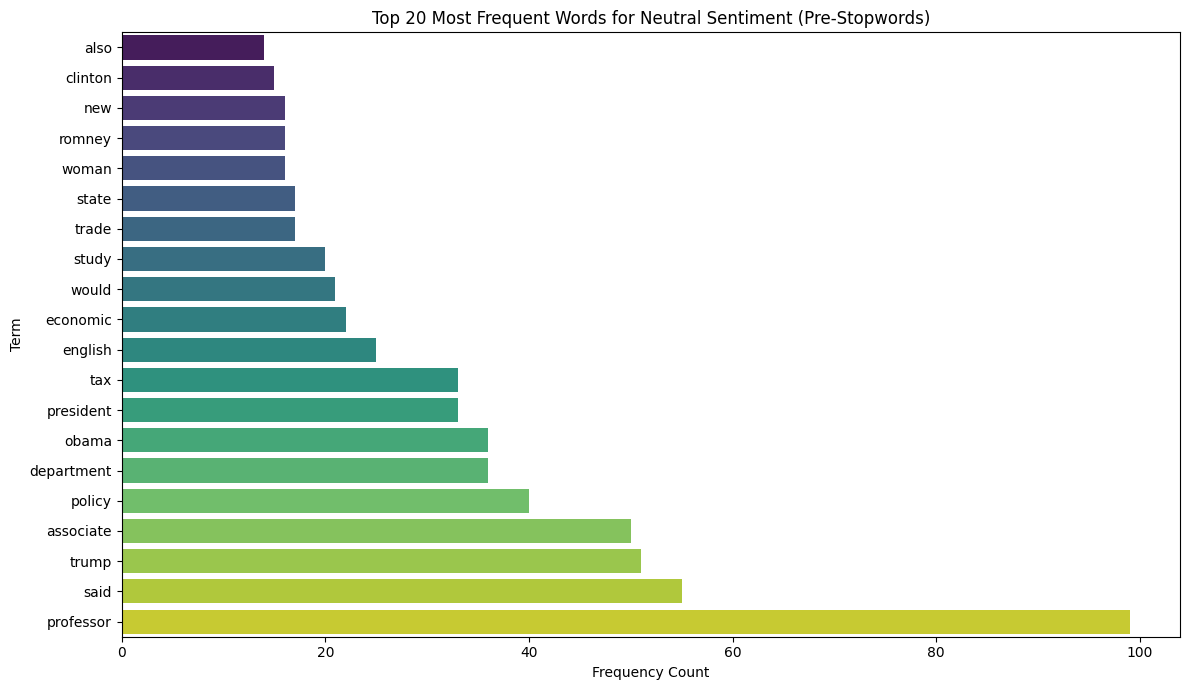

/tmp/ipython-input-2929331831.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='count', y='term', data=df_most_common_sentiment.sort_values(by='count', ascending=True), palette='viridis')


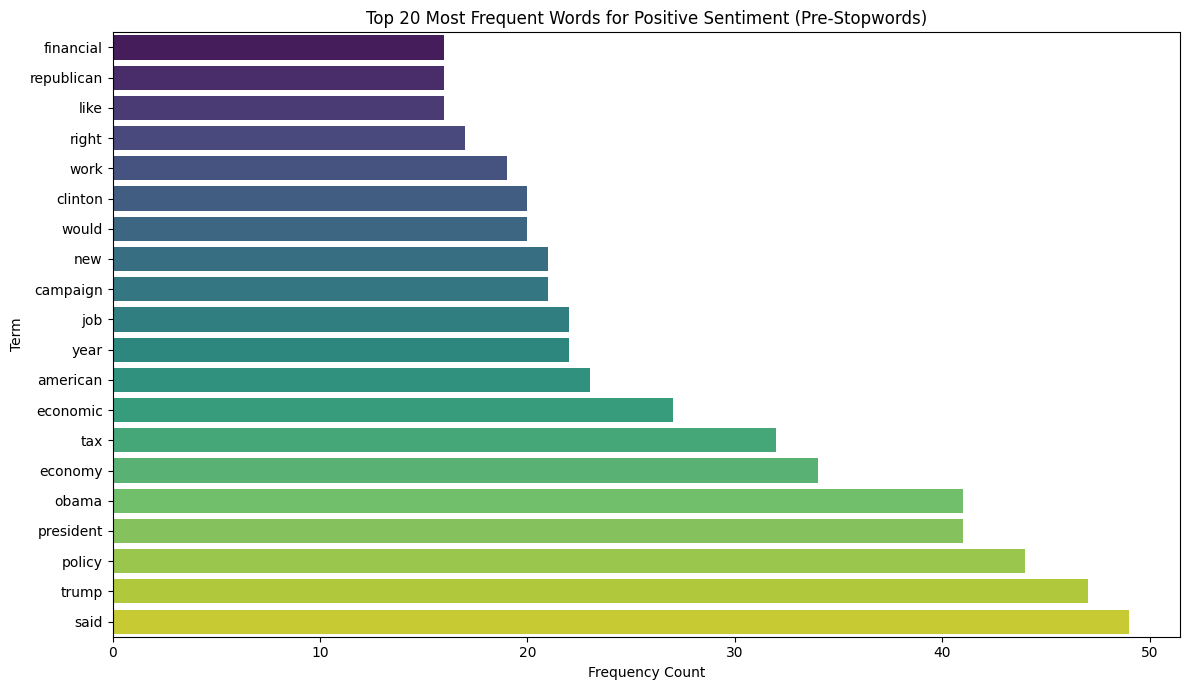

In [ ]:
# Plot top 20 words for each sentiment
for s in ["negative", "neutral", "positive"]:
    # Filter sentences for the current sentiment
    sentiment_sentences = text_econ[text_econ['sentiment'] == s]['sentence']

    # Tokenize all sentences for this sentiment using the pre-stopwords tokenizer
    all_sentiment_tokens = []
    for sentence in sentiment_sentences:
        all_sentiment_tokens.extend(nltk_tokenizer_pre_stopwords(sentence))

    # Count word frequencies
    word_counts_sentiment = Counter(all_sentiment_tokens)

    # Get the top 20 most frequent words
    top_n_words = 20
    most_common_words_sentiment = word_counts_sentiment.most_common(top_n_words)

    # Convert to DataFrame for plotting
    df_most_common_sentiment = pd.DataFrame(most_common_words_sentiment, columns=['term', 'count'])

    if not df_most_common_sentiment.empty:
        plt.figure(figsize=(12, 7))
        sns.barplot(x='count', y='term', data=df_most_common_sentiment.sort_values(by='count', ascending=True), palette='viridis')
        plt.title(f'Top {top_n_words} Most Frequent Words for {s.capitalize()} Sentiment (Pre-Stopwords)')
        plt.xlabel('Frequency Count')
        plt.ylabel('Term')
        plt.tight_layout()
        plt.show()
    else:
        print(f"Could not generate plot for {s} sentiment (pre-stopwords) due to no terms.")

The initial **sentiment distribution** across the filtered finance/economic sentences reveals a notable balance, with `negative` sentiment slightly more prevalent (268 instances) than `positive` (240 instances) and `neutral` (191 instances). This indicates a varied landscape of reporting, but with a leaning towards critical or concerning narratives.

Further examination of the **overall top 20 most frequent words** in the economic news corpus, regardless of sentiment, clearly highlights the intertwined nature of economics and politics. Terms like 'policy' (145 mentions) and 'tax' (129 mentions) are central, alongside political identifiers such as 'professor', 'campaign', 'state', 'american', 'republican', 'donald', and 'administration'. This strongly suggests that economic news is often framed within a 'political economy' context, where financial discussions are inherently linked to political figures and their actions.

## **4. TF-IDF Analysis**

Based on our preliminary inspection, we must eliminate words that contribute little semantic value to the analysis. Named entities such as 'Trump,' 'Obama,' and 'Clinton' act as noise in this context and may distort the interpretation of the TF-IDF scores. Therefore, we exclude these terms to isolate the core thematic vocabulary and optimize the analytical results.

In [ ]:
# Adding extra stopwords
import nltk
nltk.download('punkt_tab')

stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

# Add your own domain-specific stopwords here
extra_stopwords = [
    "said", "say", "also",
    "mr", "ms", "he", "him", "she", "her",
    "percent", "per", "cent",
    "monday", "tuesday", "wednesday", "thursday", "friday",
    "today", "yesterday", "year",
    "said", "also", "president", "would", "income",
    "economy", "economic", "financial", "new",
    "saying", "used", "told", "said",
    "company", "shares", "stock", "market",
    "told", "could", "trump", "obama", "clinton", "romney",
    "policy", "professor"

]

stop_words.update(extra_stopwords)

def nltk_tokenizer(text):
    if not isinstance(text, str):
        return []
    text = text.lower()
    text = re.sub(r"http\S+|www\.\S+", " ", text)   # remove URLs
    tokens = word_tokenize(text)
    tokens = [t for t in tokens if t.isalpha()]     # words only
    tokens = [t for t in tokens if t not in stop_words]
    tokens = [lemmatizer.lemmatize(t) for t in tokens]
    return tokens

# quick check
print(nltk_tokenizer(text_econ["sentence"].iloc[0])[:20])

['winner', 'wrote', 'private', 'meeting', 'republican', 'lawmaker', 'state', 'director']


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [ ]:
# Fit TF-IDF on all econ sentences
tfidf = TfidfVectorizer(
    tokenizer=nltk_tokenizer,
    ngram_range=(1, 2),   # unigrams + bigrams
    min_df=5,
    max_df=0.9
)

X_econ = tfidf.fit_transform(text_econ["sentence"])
feature_names = np.array(tfidf.get_feature_names_out())
X_econ.shape

/usr/local/lib/python3.12/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


(699, 604)

In [ ]:
def top_tfidf_terms_for_sentiment(sent_label, top_n=20):
    # rows belonging to that sentiment
    mask = text_econ["sentiment"] == sent_label
    if mask.sum() == 0:
        print(f"No rows for sentiment {sent_label}")
        return

    X_sub = X_econ[mask]

    # average TF-IDF per feature within this sentiment
    # X_sub is sparse; mean over rows:
    # (1, n_features) -> flatten to 1D
    mean_tfidf = X_sub.mean(axis=0).A1

    # top indices
    top_idx = np.argsort(mean_tfidf)[-top_n:][::-1]

    print(f"\n=== Top {top_n} TF-IDF terms for sentiment: {sent_label} ===")
    for i in top_idx:
        print(f"{feature_names[i]:<25} {mean_tfidf[i]:.4f}")

In [ ]:
def top_tfidf_terms_for_sentiment(sent_label, top_n=20):
    # rows belonging to that sentiment
    mask = text_econ["sentiment"] == sent_label
    if mask.sum() == 0:
        print(f"No rows for sentiment {sent_label}")
        return pd.DataFrame()

    X_sub = X_econ[mask.values]

    # average TF-IDF per feature within this sentiment
    # X_sub is sparse; mean over rows:
    # (1, n_features) -> flatten to 1D
    mean_tfidf = X_sub.mean(axis=0).A1

    # top indices
    top_idx = np.argsort(mean_tfidf)[-top_n:][::-1]

    terms = [feature_names[i] for i in top_idx]
    scores = [mean_tfidf[i] for i in top_idx]

    return pd.DataFrame({'term': terms, 'score': scores})

In [ ]:
# Top TF-IDF for each sentiment
for s in ["negative", "neutral", "positive"]:
    top_tfidf_terms_for_sentiment(s, top_n=20)

In [ ]:
# Install libraries

import matplotlib.pyplot as plt

In [ ]:
# X_econ: TF-IDF matrix for text_econ["sentence"]
# feature_names: np.array of token/ngram strings
# text_econ["sentiment"]: "negative"/"neutral"/"positive"

def tfidf_freq_dict_for_sentiment(sent_label, top_n=200):
    """
    Build a {term: weight} dict for a given sentiment,
    using average TF-IDF scores and keeping only top_n terms.
    """
    mask = text_econ["sentiment"] == sent_label
    if mask.sum() == 0:
        return {}

    X_sub = X_econ[mask.values]
    mean_tfidf = X_sub.mean(axis=0).A1  # (n_features,)

    # take top_n non-zero terms
    idx = np.argsort(mean_tfidf)[-top_n:]
    idx = idx[mean_tfidf[idx] > 0]

    freqs = {feature_names[i]: float(mean_tfidf[i]) for i in idx}
    return freqs

/tmp/ipython-input-934115983.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='score', y='term', data=df_top_terms, palette='viridis')


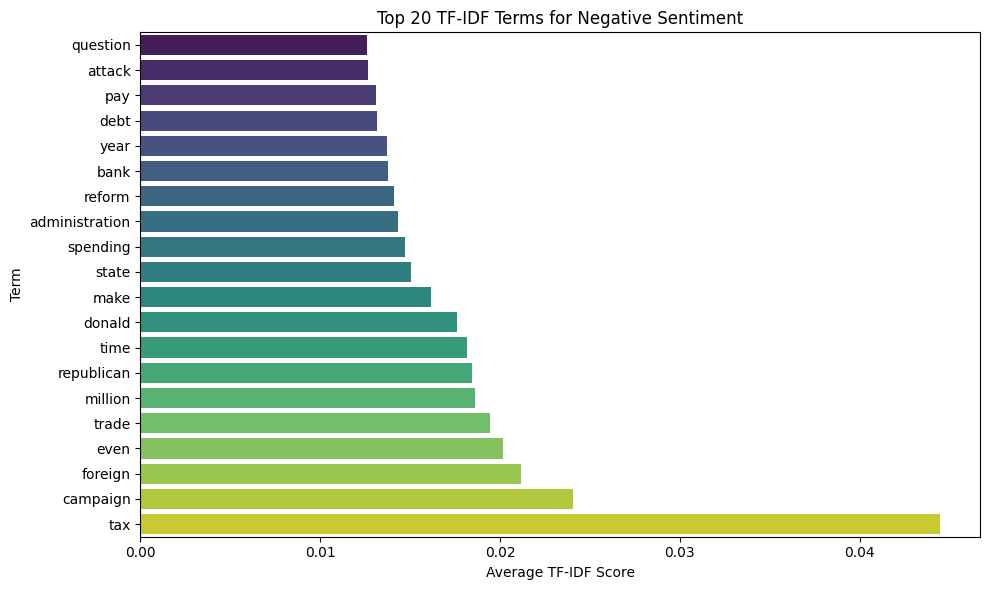

/tmp/ipython-input-934115983.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='score', y='term', data=df_top_terms, palette='viridis')


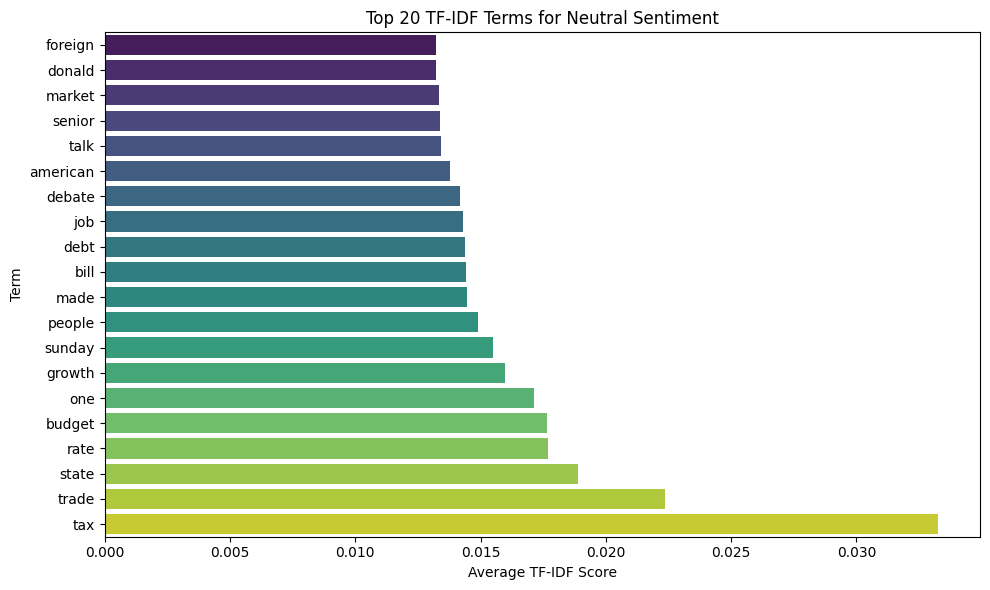

/tmp/ipython-input-934115983.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='score', y='term', data=df_top_terms, palette='viridis')


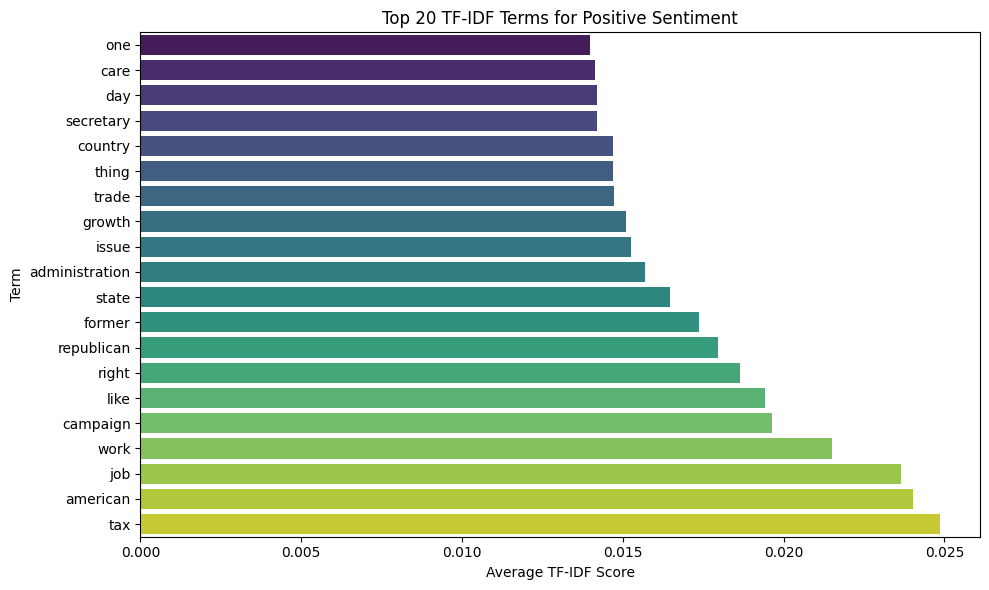

In [ ]:
# Plotting top TF-IDF terms for each sentiment as bar charts
for s in ["negative", "neutral", "positive"]:
    df_top_terms = top_tfidf_terms_for_sentiment(s, top_n=20)

    if not df_top_terms.empty:
        plt.figure(figsize=(10, 6))
        # Sort terms by score for better visualization
        df_top_terms = df_top_terms.sort_values(by='score', ascending=True)
        sns.barplot(x='score', y='term', data=df_top_terms, palette='viridis')
        plt.title(f'Top 20 TF-IDF Terms for {s.capitalize()} Sentiment')
        plt.xlabel('Average TF-IDF Score')
        plt.ylabel('Term')
        plt.tight_layout()
        plt.show()
    else:
        print(f"Could not generate plot for {s} sentiment due to no terms.")

Delving into **sentiment-specific TF-IDF terms** provides a deeper understanding of linguistic framing:

*   **Negative Sentiment:** The top TF-IDF terms for negative news include 'tax', 'policy', 'campaign', 'foreign', 'trade', 'million', 'republican', 'foreign policy', 'time', 'donald', 'spending', 'administration', and 'debt'. This vocabulary is indicative of reporting that focuses on burdens, financial strain, and conflict, often associating economic issues with specific political figures or policies perceived as problematic.

*   **Neutral Sentiment:** Neutral reporting is characterized by terms like 'policy', 'tax', 'trade', 'state', 'rate', 'budget', 'growth', 'people', 'made', 'bill', 'debt', 'job', 'american', and 'market'. These words are more descriptive and technical, reflecting a factual or explanatory approach to economic events and policies, without strong emotional valence.

*   **Positive Sentiment:** Positive news emphasizes terms such as 'policy', 'tax', 'american', 'job', 'work', 'campaign', 'like', 'right', 'republican', 'former', 'state', 'administration', 'growth', 'issue', 'trade', 'country', 'secretary', 'day', and 'care'. This framing centers on benefits, opportunities, and positive outcomes, linking economic success to job creation, growth, and general well-being.



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Saved word cloud to /content/drive/MyDrive/wordcloud_negative.png


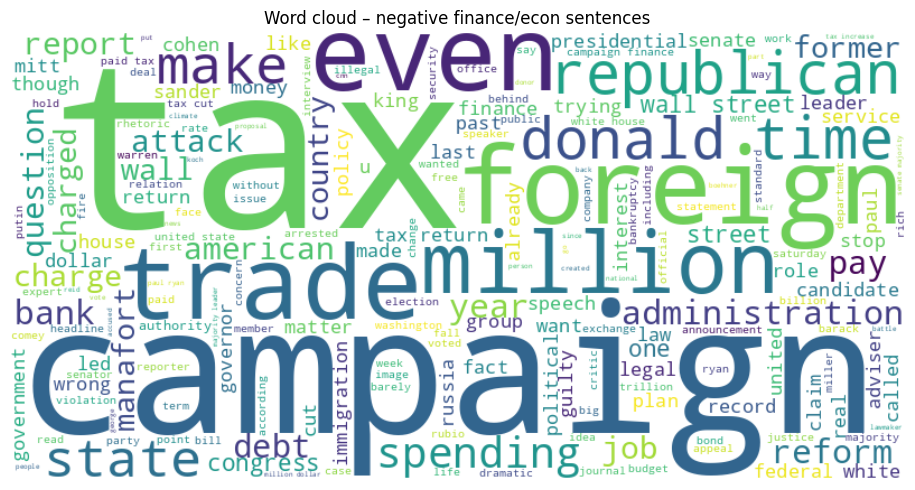

Saved word cloud to /content/drive/MyDrive/wordcloud_neutral.png


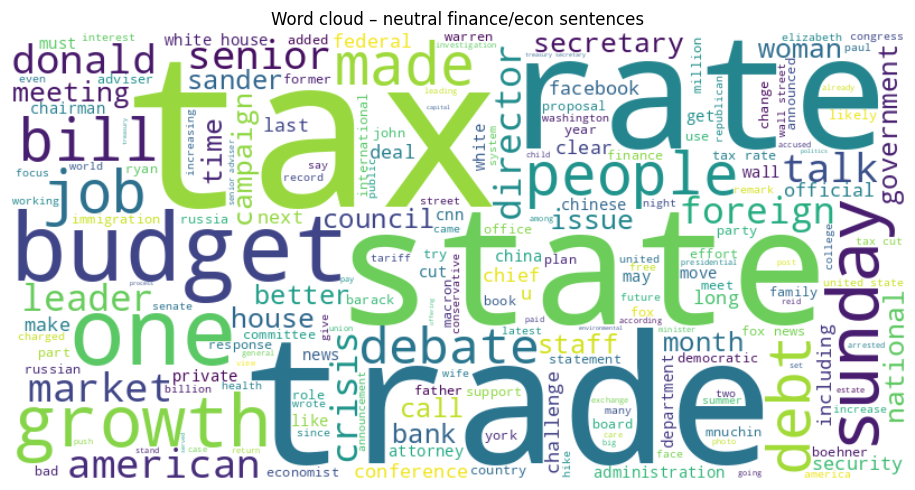

Saved word cloud to /content/drive/MyDrive/wordcloud_positive.png


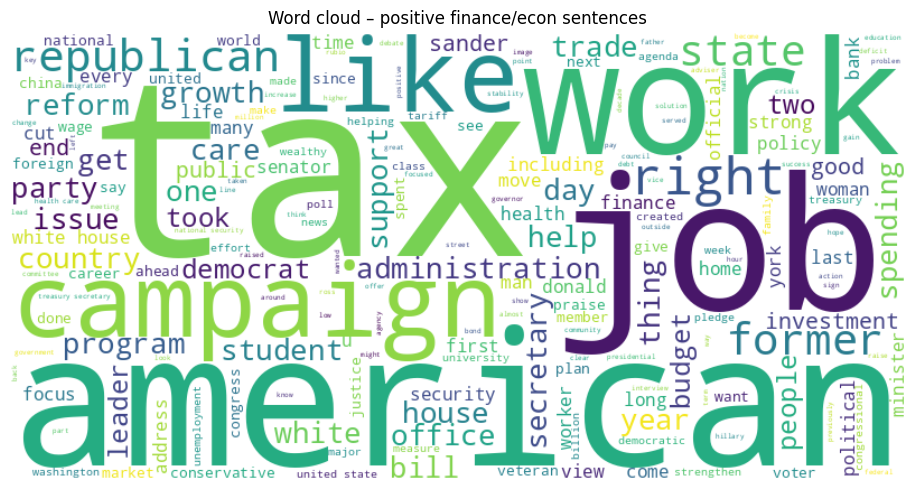

In [ ]:
# Plotting word cloud
from google.colab import drive
drive.mount('/content/drive')

def plot_wordcloud_for_sentiment(sent_label, top_n=200):
    freqs = tfidf_freq_dict_for_sentiment(sent_label, top_n=top_n)
    if not freqs:
        print(f"No terms for sentiment: {sent_label}")
        return

    wc = WordCloud(
        width=800,
        height=400,
        background_color="white"
    ).generate_from_frequencies(freqs)

    plt.figure(figsize=(10, 5))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"Word cloud – {sent_label} finance/econ sentences")
    plt.tight_layout()

    # Save the figure before showing it
    filename = f"/content/drive/MyDrive/wordcloud_{sent_label}.png"
    plt.savefig(filename, bbox_inches='tight', pad_inches=0)
    print(f"Saved word cloud to {filename}")

    plt.show()

for s in ["negative", "neutral", "positive"]:
    plot_wordcloud_for_sentiment(s, top_n=200)

## **5. Conclusion and Policy Relevance**

This analysis highlights a critical challenge for policymakers: Communication Asymmetry.

My findings suggest that "Neutral" news frames policy in technical, inaccessible language, while "Negative" news uses highly emotionally charged framing. This creates a disadvantage for incumbents trying to tout economic stability. Stability reads as "boring" (neutral/technical), while instability reads as "urgent" (negative/emotional).

**Policy Implication:** <br>
For communication directors and policymakers, simply relying on "good stats" is insufficient. To combat the "Vibecession," political messaging must actively inject positive emotional framing into the technical successes of the economy. They must move the language from the "Neutral/Technical" bucket to the "Positive/Emotive" bucket to effectively resonate with the public.